Episode    1 | reward  -50 | ε=0.846
Episode  100 | reward  -10 | ε=0.050
Episode  200 | reward    1 | ε=0.050
Episode  300 | reward  -17 | ε=0.050
Episode  400 | reward    4 | ε=0.050
Episode  500 | reward    4 | ε=0.050
Episode  600 | reward    4 | ε=0.050
Episode  700 | reward    4 | ε=0.050
Episode  800 | reward    2 | ε=0.050
Episode  900 | reward    3 | ε=0.050
Episode 1000 | reward    4 | ε=0.050
Training finished — saved figure to training_curves.png


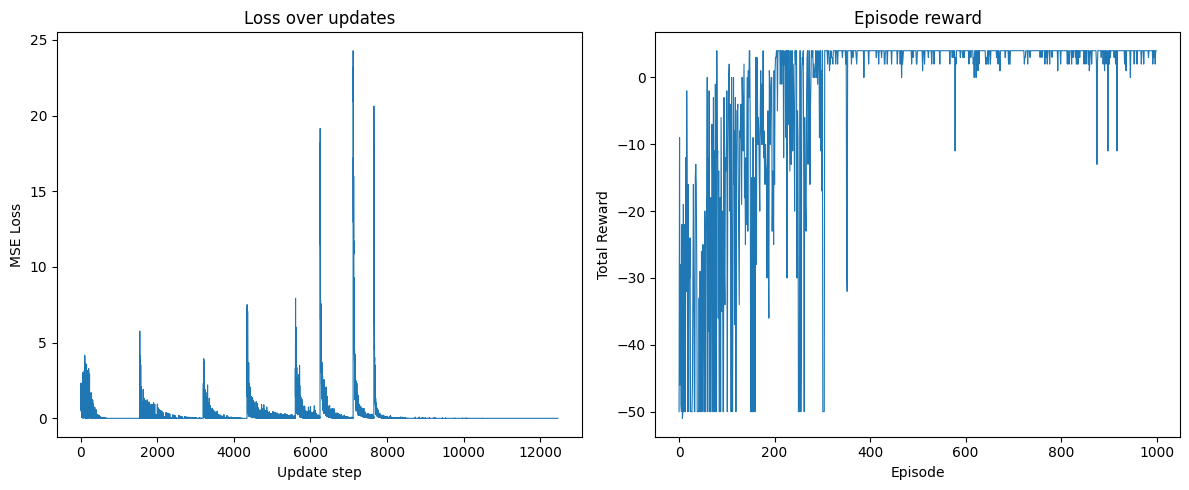

In [8]:
from __future__ import annotations

import argparse
import math
import random
from collections import deque
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# ---------------------------------------------------------------------------
# Environment wrapper – adapts legacy Gridworld
# ---------------------------------------------------------------------------
from sample_data.Gridworld import Gridworld  # noqa: E402

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class GridEnvWrapper:
    ACTIONS = {0: "u", 1: "d", 2: "l", 3: "r"}

    def __init__(self, size: int = 4):
        self.raw = Gridworld(size=size, mode="static")
        self.size = size

    # one‑hot (4 planes) → flatten 64
    def _state(self) -> np.ndarray:
        layers = np.zeros((4, self.size, self.size), dtype=np.float32)
        mapping = {"Player": 0, "Goal": 1, "Pit": 2, "Wall": 3}
        for name, piece in self.raw.board.components.items():
            ch = mapping[name]; r, c = piece.pos
            layers[ch, r, c] = 1.0
        return layers.flatten()

    def reset(self) -> np.ndarray:
        self.raw.initGridStatic()
        return self._state()

    def step(self, idx: int) -> Tuple[np.ndarray, float, bool]:
        self.raw.makeMove(self.ACTIONS[idx])
        r = self.raw.reward(); done = r in {10, -10}
        return self._state(), float(r), done

    def render(self):
        print(self.raw.display())

# ---------------------------------------------------------------------------
# Replay buffer & DQN network
# ---------------------------------------------------------------------------
class ReplayBuffer:
    def __init__(self, cap: int):
        self.buf: deque = deque(maxlen=cap)
    def push(self, s, a, r, s2, d):
        self.buf.append((s, a, r, s2, d))
    def sample(self, batch: int):
        b = random.sample(self.buf, batch)
        s, a, r, s2, d = map(np.array, zip(*b))
        return (
            torch.tensor(s, dtype=torch.float32, device=device),
            torch.tensor(a, dtype=torch.int64,  device=device).unsqueeze(1),
            torch.tensor(r, dtype=torch.float32, device=device).unsqueeze(1),
            torch.tensor(s2, dtype=torch.float32, device=device),
            torch.tensor(d, dtype=torch.float32, device=device).unsqueeze(1),
        )
    def __len__(self):
        return len(self.buf)

class DQN(nn.Module):
    def __init__(self, inp: int, hid: int, n_act: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(inp, hid), nn.ReLU(), nn.Linear(hid, n_act)
        )
    def forward(self, x):
        return self.net(x)

# ---------------------------------------------------------------------------
# Helper functions
# ---------------------------------------------------------------------------

def eps_greedy(state: np.ndarray, policy: DQN, n_act: int, step: int,
               eps_start: float, eps_end: float, eps_decay: float) -> int:
    eps = eps_end + (eps_start - eps_end) * math.exp(-step / eps_decay)
    if random.random() < eps:
        return random.randrange(n_act)
    with torch.no_grad():
        q = policy(torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0))
        return int(q.argmax())


def optimize(policy: DQN, target: DQN, buf: ReplayBuffer, opt: torch.optim.Optimizer,
             batch: int, gamma: float) -> float | None:
    if len(buf) < batch:
        return None
    s, a, r, s2, d = buf.sample(batch)
    q = policy(s).gather(1, a)
    with torch.no_grad():
        q_next = target(s2).max(1)[0].unsqueeze(1)
        tgt = r + gamma * q_next * (1 - d)
    loss = nn.functional.mse_loss(q, tgt)
    opt.zero_grad(); loss.backward(); opt.step()
    return float(loss.item())

# ---------------------------------------------------------------------------
# Training
# ---------------------------------------------------------------------------

def train(cfg):
    env = GridEnvWrapper()
    state_dim = env.reset().shape[0]
    n_act = 4

    policy, target = DQN(state_dim, 128, n_act).to(device), DQN(state_dim, 128, n_act).to(device)
    target.load_state_dict(policy.state_dict())

    opt = optim.Adam(policy.parameters(), lr=cfg.lr)
    buf = ReplayBuffer(cfg.buffer_capacity)

    rewards: List[float] = []
    losses:  List[float] = []

    step = 0
    for ep in range(1, cfg.num_episodes + 1):
        s = env.reset(); ep_r = 0
        for _ in range(cfg.max_steps):
            a = eps_greedy(s, policy, n_act, step, cfg.eps_start, cfg.eps_end, cfg.eps_decay)
            step += 1
            s2, r, done = env.step(a)
            buf.push(s, a, r, s2, done)
            s = s2; ep_r += r
            l = optimize(policy, target, buf, opt, cfg.batch_size, cfg.gamma)
            if l is not None:
                losses.append(l)
            if done:
                break
        rewards.append(ep_r)

        if ep % cfg.target_update_interval == 0:
            target.load_state_dict(policy.state_dict())

        if ep % 100 == 0 or ep == 1:
            eps_now = max(cfg.eps_end, cfg.eps_start * math.exp(-step / cfg.eps_decay))
            print(f"Episode {ep:4d} | reward {ep_r:4.0f} | ε={eps_now:.3f}")

    # plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(losses, lw=0.8); ax1.set_title("Loss over updates"); ax1.set_xlabel("Update step"); ax1.set_ylabel("MSE Loss")
    ax2.plot(rewards, lw=0.8); ax2.set_title("Episode reward"); ax2.set_xlabel("Episode"); ax2.set_ylabel("Total Reward")
    plt.tight_layout(); fig.savefig("training_curves.png")
    print("Training finished — saved figure to training_curves.png")

# ---------------------------------------------------------------------------
# CLI
# ---------------------------------------------------------------------------

def args_from_cli():
    p = argparse.ArgumentParser(description="Naive DQN with loss curve")
    p.add_argument("--num_episodes", type=int, default=1000)
    p.add_argument("--max_steps", type=int, default=50)
    p.add_argument("--batch_size", type=int, default=64)
    p.add_argument("--gamma", type=float, default=0.99)
    p.add_argument("--buffer_capacity", type=int, default=10000)
    p.add_argument("--lr", type=float, default=1e-3)
    p.add_argument("--target_update_interval", type=int, default=50)
    p.add_argument("--eps_start", type=float, default=1.0)
    p.add_argument("--eps_end", type=float, default=0.05)
    p.add_argument("--eps_decay", type=float, default=300)
    a, _ = p.parse_known_args(); return a

if __name__ == "__main__":
    train(args_from_cli())
